In [1]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import random as rd

df = pd.read_csv("house_data_sampled.csv")
df.head()
df.columns



Index(['Unnamed: 0', 'id', 'date', 'price', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

Linear function:  
245.5 x + 1.267e+04


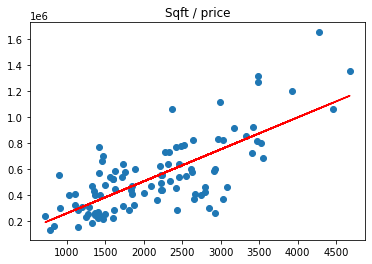

In [2]:
plt.scatter(df['sqft_living'], df["price"])
z = np.polyfit(df['sqft_living'], df["price"], 1)
p = np.poly1d(z)
print(f"Linear function: {p}")
trend_h = p(df['sqft_living'])
plt.plot(df['sqft_living'],trend_h, "r-")
plt.title("Sqft / price")
plt.show()

<AxesSubplot:>

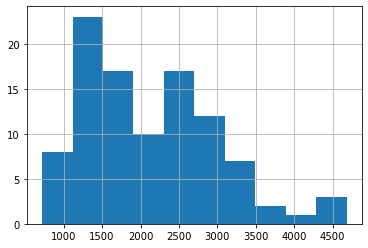

In [18]:
df['sqft_living'].hist()

<AxesSubplot:>

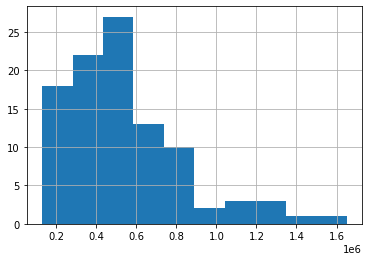

In [19]:
df['price'].hist()

<AxesSubplot:>

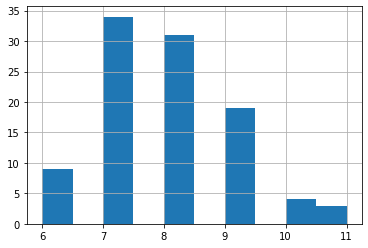

In [20]:
df['grade'].hist()

In [3]:
data = {'N': len(df['sqft_living']),
        'sqft': df['sqft_living']}
model_1_prior = CmdStanModel(stan_file='stan_1_ppc.stan')
model_1_prior_simulated = model_1_prior.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [4]:
model_1_prior_simulated.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,0.0,NaN,0.0,0.00,0.0,0.0,NaN,NaN,NaN
alpha,44000.0,77.000,2500.0,40000.00,44000.0,48000.0,1100.0,16000.0,1.0
beta,280.0,4.500,150.0,12.00,280.0,530.0,1200.0,17000.0,1.0
sigma,2.0,0.055,1.9,0.12,1.4,5.9,1200.0,18000.0,1.0
price[1],814061.0,12623.000,428896.0,78718.00,823729.0,1520490.0,1154.0,17230.0,1.0
...,...,...,...,...,...,...,...,...,...
price[96],400031.0,5838.000,198338.0,60020.00,405630.0,727602.0,1154.0,17227.0,1.0
price[97],662250.0,10135.000,344357.0,71860.00,671005.0,1229770.0,1154.0,17229.0,1.0
price[98],852703.0,13257.000,450416.0,80461.00,862714.0,1594500.0,1154.0,17230.0,1.0


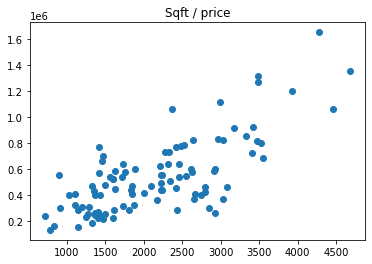

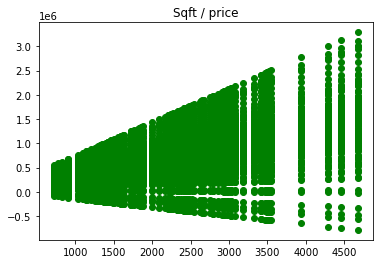

In [5]:
prices_sim=model_1_prior_simulated.stan_variable('price')
plt.scatter(df['sqft_living'], df["price"])
plt.title("Sqft / price")
plt.show()

prices_sim=model_1_prior_simulated.stan_variable('price')

for i in range(0,len(df['sqft_living'])):
    plt.scatter(df['sqft_living'], prices_sim[i], color="g")

plt.title("Sqft / price")
plt.show()

In [6]:
data = {'N': len(df['sqft_living']),
        'sqft': df['sqft_living']}
model_2_prior = CmdStanModel(stan_file='stan_2_ppc.stan')
model_2_prior_simulated = model_2_prior.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


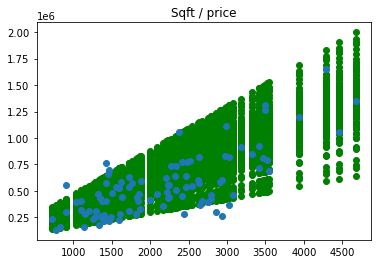

In [7]:
prices_sim=model_2_prior_simulated.stan_variable('price')

for i in range(0,len(df['sqft_living'])):
    plt.scatter(df['sqft_living'], prices_sim[i], color="g")

plt.scatter(df['sqft_living'], df["price"])

plt.title("Sqft / price")
plt.show()

(array([ 8., 23., 17., 10., 17., 12.,  7.,  2.,  1.,  3.]),
 array([ 376426. ,  557448.4,  738470.8,  919493.2, 1100515.6, 1281538. ,
        1462560.4, 1643582.8, 1824605.2, 2005627.6, 2186650. ]),
 <BarContainer object of 10 artists>)

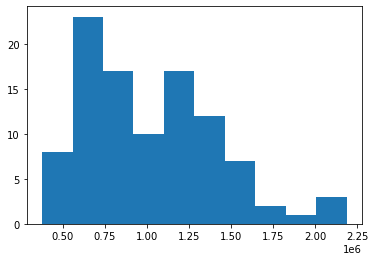

In [49]:
plt.hist(prices_sim[10], bins=10)

<AxesSubplot:>

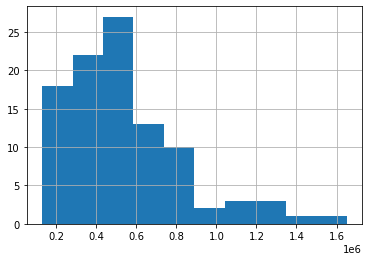

In [46]:
df['price'].hist()

In [12]:
data = {'N': len(df['sqft_living']),
        'sqft': df['sqft_living'],
        'price': df['price']}
model_1_posterior = CmdStanModel(stan_file='stan_1_posterior.stan')
model_1_posterior_simulated = model_1_posterior.sample(data=data, seed=21370204)

INFO:cmdstanpy:compiling stan file /home/nicolas/Projects/DA_project/stan_1_posterior.stan to exe file /home/nicolas/Projects/DA_project/stan_1_posterior
INFO:cmdstanpy:compiled model executable: /home/nicolas/Projects/DA_project/stan_1_posterior
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


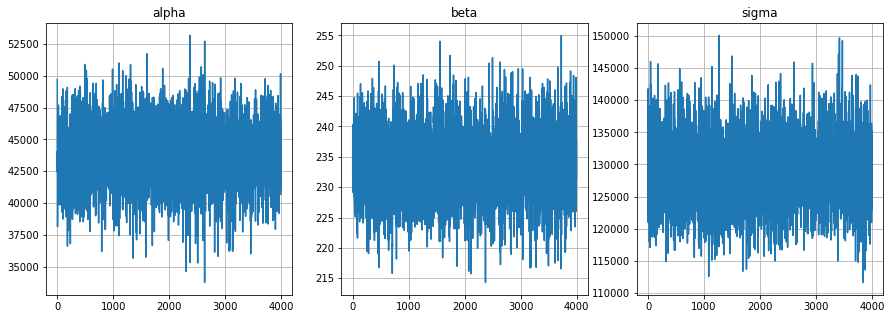

,mean,sd,hdi_3%,hdi_97%
alpha,43750.20,2417.83,39178.20,48316.80
beta,233.69,5.63,223.15,244.42
sigma,128636.14,5364.01,118432.00,138528.00


In [13]:
alpha_sim = model_1_posterior_simulated.stan_variable('alpha')
beta_sim = model_1_posterior_simulated.stan_variable('beta')
sigma_sim = model_1_posterior_simulated.stan_variable('sigma')
price_sim = model_1_posterior_simulated.stan_variable('price_sim')

fig, axs = plt.subplots(1,3)
fig.set_size_inches(15, 5)
axs[0].plot(alpha_sim)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].plot(beta_sim)
axs[1].grid()
axs[1].set_title('beta')
axs[2].plot(sigma_sim)
axs[2].grid()
axs[2].set_title('sigma')
plt.show()

az.summary(model_1_posterior_simulated,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

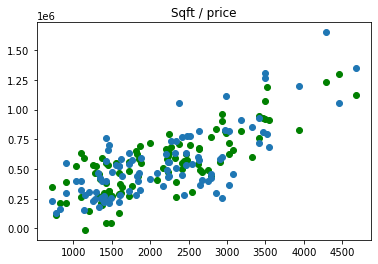

In [14]:
prices_sim=model_1_posterior_simulated.stan_variable('price_sim')

# for i in range(0,len(df['sqft_living'])):
plt.scatter(df['sqft_living'], prices_sim[1], color="g")

plt.scatter(df['sqft_living'], df["price"])

plt.title("Sqft / price")
plt.show()

## Adding second predictor to model

Linear function:  
1.748e+05 x - 8.289e+05


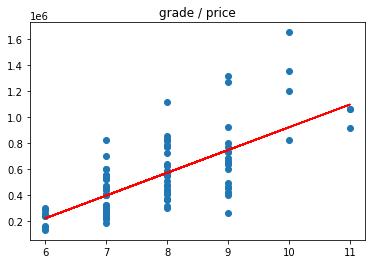

In [60]:
plt.scatter(df['grade'], df["price"])
z = np.polyfit(df['grade'], df["price"], 1)
p = np.poly1d(z)
print(f"Linear function: {p}")
trend_h = p(df['grade'])
plt.plot(df['grade'], trend_h, "r-")
plt.title("grade / price")
plt.show()

Line(point=Point([2.1538600e+03, 7.8400000e+00, 5.4151708e+05]), direction=Vector([-2.22341431e-03, -2.77067460e-06, -9.99997528e-01]))


(<Figure size 432x288 with 1 Axes>, <Axes3DSubplot:>)

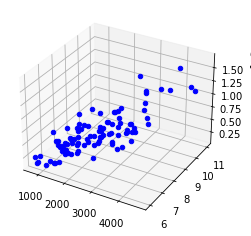

In [82]:
from skspatial.objects import Line
from skspatial.objects import Points
from skspatial.plotting import plot_3d

points1 = []
for i in range(len(df["sqft_living"])):
    points1.append([df["sqft_living"][i], df["grade"][i],df["price"][i]])

points1 = Points(points1)

# print(points1)

line_fit = Line.best_fit(points1)

print(line_fit)

plot_3d(
    line_fit.plotter(c='k'),
    points1.plotter(c='b', depthshade=False),
)

In [81]:
print(df["sqft_living"].max())
print(df["grade"].max())
print(df["price"].max())

4680
11
1650000.0


Line(point=Point([2.1538600e+03, 7.8400000e+00, 5.4151708e+05]), direction=Vector([-2.22341431e-03, -2.77067460e-06, -9.99997528e-01]))


(<Figure size 432x288 with 1 Axes>, <Axes3DSubplot:>)

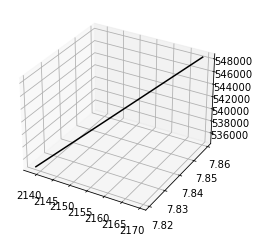

In [69]:
line_fit = Line.best_fit(points1)

print(line_fit)

plot_3d(
    line_fit.plotter(t_1=-7000, t_2=7000, c='k'),
)

In [41]:
data = {'N': len(df['sqft_living']),
        'sqft': df['sqft_living'],
        'grade': df['grade']}
model_two_param = CmdStanModel(stan_file='two_params_ppc.stan')
model_two_param_simulated = model_two_param.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

INFO:cmdstanpy:compiling stan file /home/nicolas/Projects/DA_project/two_params_ppc.stan to exe file /home/nicolas/Projects/DA_project/two_params_ppc
INFO:cmdstanpy:compiled model executable: /home/nicolas/Projects/DA_project/two_params_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:compiling stan file /home/nicolas/Projects/DA_project/two_params_ppc.stan to exe file /home/nicolas/Projects/DA_project/two_params_ppc
INFO:cmdstanpy:compiled model executable: /home/nicolas/Projects/DA_project/two_params_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


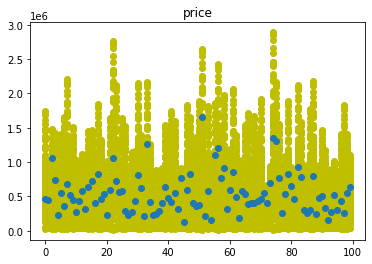

In [95]:
data = {'N': len(df['sqft_living']),
        'sqft': df['sqft_living'],
        'grade': df['grade']}
model_two_param = CmdStanModel(stan_file='two_params_ppc.stan')
model_two_param_simulated = model_two_param.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

prices_sim=model_two_param_simulated.stan_variable('price')

x = range(len(df["sqft_living"]))

for i in range(0,len(df['sqft_living'])):
    plt.scatter(x, prices_sim[i], color="y")

plt.scatter(x, df["price"])

plt.title("price")
plt.show()

<AxesSubplot:>

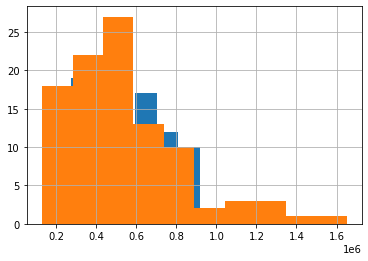

In [94]:
plt.hist(prices_sim[10], bins=10)
df["price"].hist(bins=10)

INFO:cmdstanpy:compiling stan file /home/nicolas/Projects/DA_project/two_params.stan to exe file /home/nicolas/Projects/DA_project/two_params
INFO:cmdstanpy:compiled model executable: /home/nicolas/Projects/DA_project/two_params
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/nicolas/Projects/DA_project/two_params.hpp /home/nicolas/Projects/DA_project/two_params.stan
Warning in '/home/nicolas/Projects/DA_project/two_params.stan', line 5, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/nicolas/Projects/DA_project/two_params.stan', line 29, column 3: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatic


INFO:cmdstanpy:CmdStan done processing.


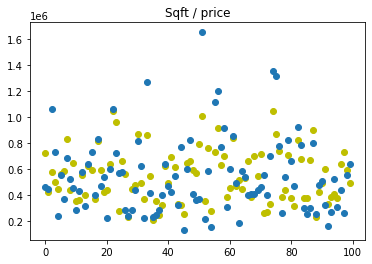

In [101]:
data = {'N': len(df['sqft_living']),
        'sqft': df['sqft_living'],
        'grade': df['grade'],
        'price': df['price']}
model_two_param = CmdStanModel(stan_file='two_params.stan')
model_two_param_simulated = model_two_param.sample(data=data, seed=21370204)

prices_sim=model_two_param_simulated.stan_variable('prices')

x = range(len(df["sqft_living"]))

plt.scatter(x, prices_sim[i], color="y")

plt.scatter(x, df["price"])

plt.title("Sqft / price")
plt.show()

In [16]:
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm

X = df[['sqft_living','sqft_lot']] # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y = df['price']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# prediction with sklearn
New_Interest_Rate = 2.75
New_Unemployment_Rate = 5.3
print ('Predicted Stock Index Price: \n', regr.predict([[New_Interest_Rate ,New_Unemployment_Rate]]))

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)


Intercept: 
 6108.534973076545
Coefficients: 
 [242.09519249   1.04518381]
Predicted Stock Index Price: 
 [6779.8362266]
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     60.34
Date:                Mon, 13 Jun 2022   Prob (F-statistic):           9.42e-18
Time:                        14:46:25   Log-Likelihood:                -1357.8
No. Observations:                 100   AIC:                             2722.
Df Residuals:                      97   BIC:                             2729.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
---------

c:\miniconda3\envs\cmdstan\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [17]:
data = {'N': len(df['sqft_living']),
        'sqft_living': df['sqft_living'],
        'sqft_lot': df['sqft_lot'],
        'price': df['price']}
model_two_param = CmdStanModel(stan_file='two_params.stan')
model_two_param_simulated = model_two_param.sample(data=data, seed=21370204)

prices_sim=model_two_param_simulated.stan_variable('prices')

x = range(len(df["sqft_living"]))

plt.scatter(x, prices_sim[i], color="y")

plt.scatter(x, df["price"])

plt.title("Sqft / price")
plt.show()

INFO:cmdstanpy:compiling stan file C:\STUFF\8th_semester\DA_project\two_params.stan to exe file C:\STUFF\8th_semester\DA_project\two_params.exe
INFO:cmdstanpy:compiled model executable: C:\STUFF\8th_semester\DA_project\two_params.exe
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/STUFF/8th_semester/DA_project/two_params.hpp C:/STUFF/8th_semester/DA_project/two_params.stan
Warning in 'C:/STUFF/8th_semester/DA_project/two_params.stan', line 6, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:/STUFF/8th_semester/DA_project/two_params.stan', line 29, column 3: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed auto


INFO:cmdstanpy:CmdStan done processing.


RuntimeError: Error during sampling:
Exception: variable does not exist; processing stage=data initialization; variable name=grade; base type=double (in 'C:/STUFF/8th_semester/DA_project/two_params.stan', line 5, column 4 to column 21)
Exception: variable does not exist; processing stage=data initialization; variable name=grade; base type=double (in 'C:/STUFF/8th_semester/DA_project/two_params.stan', line 5, column 4 to column 21)
Exception: variable does not exist; processing stage=data initialization; variable name=grade; base type=double (in 'C:/STUFF/8th_semester/DA_project/two_params.stan', line 5, column 4 to column 21)
Exception: variable does not exist; processing stage=data initialization; variable name=grade; base type=double (in 'C:/STUFF/8th_semester/DA_project/two_params.stan', line 5, column 4 to column 21)Command and output files:
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\STUFF\\8th_semester\\DA_project\\two_params.exe', 'id=1', 'random', 'seed=21370204', 'data', 'file=C:\\Users\\PIOTRK~1\\AppData\\Local\\Temp\\tmpggh2bub0\\ngypnirn.json', 'output', 'file=C:\\Users\\PIOTRK~1\\AppData\\Local\\Temp\\tmpggh2bub0\\two_params-20220613144733_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[1, 1, 1, 1]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\PIOTRK~1\AppData\Local\Temp\tmpggh2bub0\two_params-20220613144733_1.csv
 console_msgs (if any):
	C:\Users\PIOTRK~1\AppData\Local\Temp\tmpggh2bub0\two_params-20220613144733_0-stdout.txt